# Time Series Analysis and Forecasting Using Gradient Boosted Decision Trees

This notebook shows how to decompose time series and reconstruct unobserved (latent) components using generic regression models. We use Gradient Boosted Decision Trees (LightGBM and XGBoost), but the same analysis can be done with other model types.

## Detailed Description
Please see blog post [D006](https://github.com/ikatsov/tensor-house/blob/master/resources/descriptions.md) for more details. 

## Data
This notebook generates synthetic data internally, no external datset are used.

---

# Step 1: Generate the Data

We fist generate a data sample that simulates several effects that are commonly found in enterprise applications (e.g. sales data). More specifically, the generated series comprises the following components:
* Trend. Linear market trend. 
* Seasonality. Quarterly demand waves. 
* Covariates with a linear link function. External factors that have near-linear influence on the observed series. For instance, the relationship between price and demand is sometimes modeled as a linear fiunction. We assume that these covariates are observed directly. 
* Covariates with a non-linear link function. External factors that have non-linear influence on the observed signal. For instance, some common price-demand models are non-linear. We assume that the covariates are observed directly, but the non-linear link function is unknown. We use a steep sigmoid function as an example.  
* Covariates with memory effects. Some external factors can influce the observed signal with a delay. For example, deep discounts can boost current sales bu reduce future sales becasue of stockpiling. This can be modeled as a special type of a link function e.g. a convolution with some impulse response function. We observe the original covariate, but not the link function or transformed covariate. 

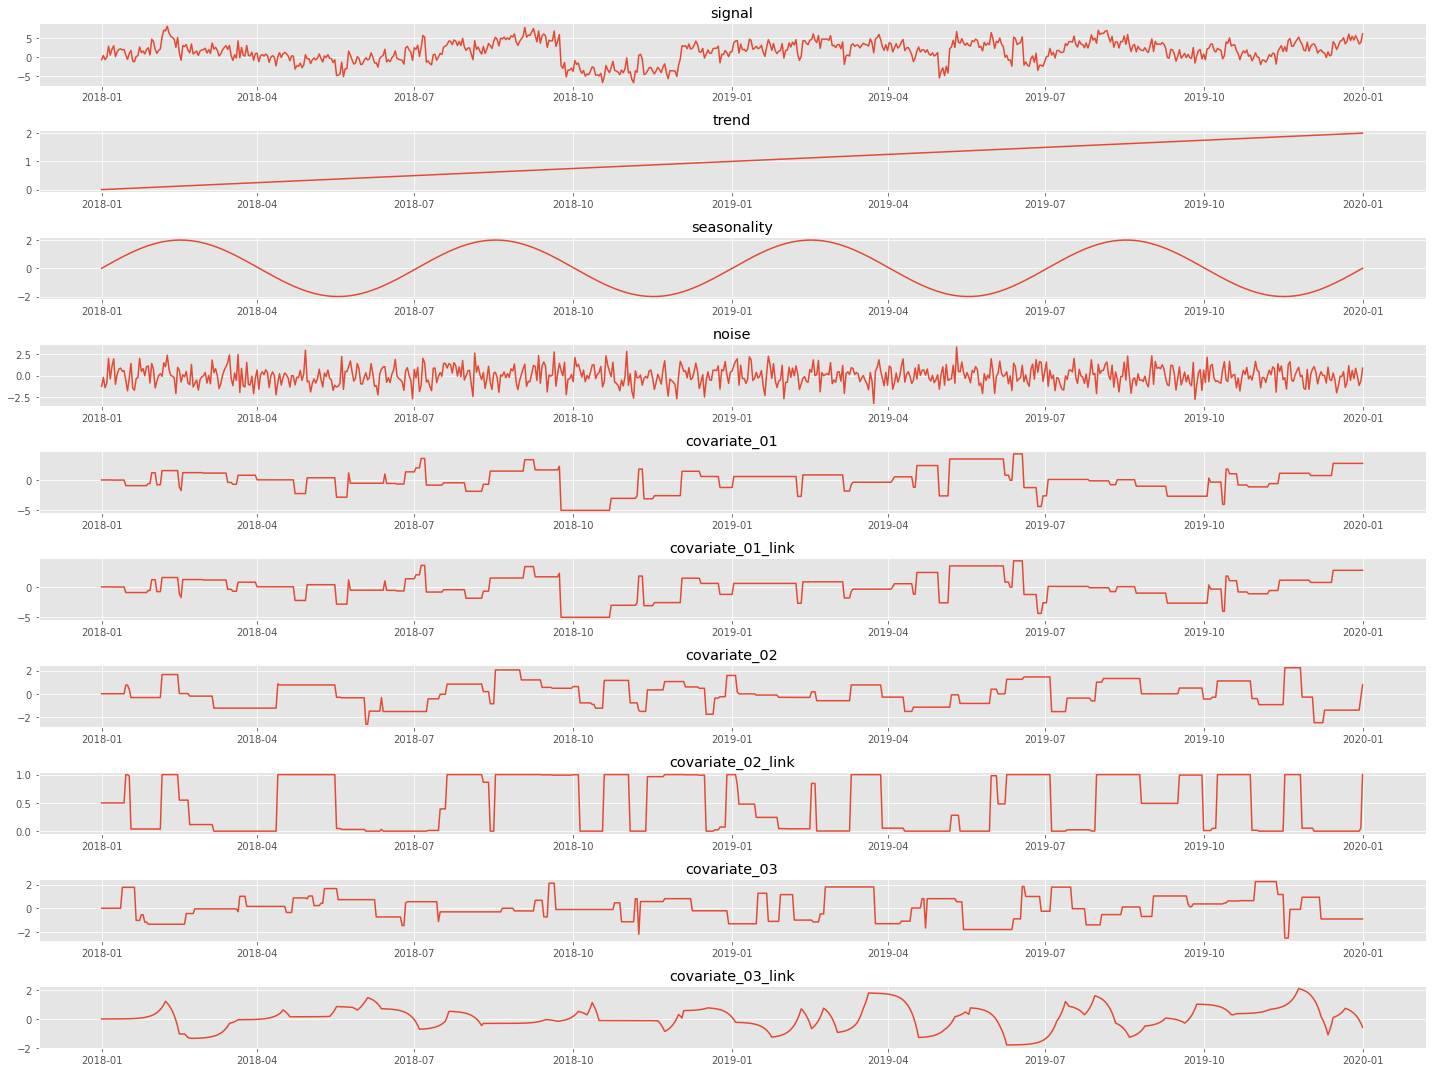

In [107]:
import numpy as np
import pandas as pd
import datetime
import collections
from matplotlib import pylab as plt
plt.style.use('ggplot')
import seaborn as sns
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.options.mode.chained_assignment = None

from pdpbox import pdp
import lightgbm
import xgboost as xgb
import shap
shap.initjs()
    
def step_series(n, mean, scale, n_steps):
    s = np.zeros(n)
    step_idx = np.random.randint(0, n, n_steps)
    value = mean
    for t in range(n):
        s[t] = value
        if t in step_idx:
            value = mean + scale * np.random.randn()
    return s

def linear_link(x): 
    return x

def sigmoid_link(x, scale = 10):
    return 1 / (1 + np.exp(-scale*x))

def mem_link(x, length = 50):
    mfilter = np.exp(np.linspace(-10, 0, length))
    return np.convolve(x, mfilter/np.sum(mfilter), mode='same')

def create_signal(links = [linear_link, sigmoid_link, mem_link]):
    days_year = 365
    quaters_year = 4
    days_week = 7
    
    # two years of data, daily resolution
    idx = pd.date_range(start='2018-01-01', end='2020-01-01', freq='D') 

    df = pd.DataFrame(index=idx, dtype=float)
    df = df.fillna(0.0)
    
    n = len(df.index)
    trend = np.zeros(n)
    seasonality = np.zeros(n)
    for t in range(n):
        trend[t] = 2.0 * t/n
        seasonality[t] = 2.0 * np.sin(np.pi * t/days_year*quaters_year)
    
    covariates = [step_series(n, 0, 2.0, 80), step_series(n, 0, 1.0, 80), step_series(n, 0, 1.0, 80)]
    covariate_links = [ links[i](covariates[i]) for i in range(3) ]
    
    noise = np.random.randn(n)
    
    signal = trend + seasonality + np.sum(covariate_links, axis=0) + noise
    
    df['signal'], df['trend'], df['seasonality'], df['noise'] = signal, trend, seasonality, noise
    for i in range(3):
        df[f'covariate_0{i+1}'] = covariates[i]
        df[f'covariate_0{i+1}_link'] = covariate_links[i]
    
    return df

df = create_signal()
fig, ax = plt.subplots(len(df.columns), figsize=(20, 15))
for i, c in enumerate(df.columns):
    ax[i].plot(df.index, df[c])
    ax[i].set_title(c)

plt.tight_layout()
plt.show()

# Step 2: Fit the Model and Make the Forecast

[50]	training's mape: 0.268774	training's l2: 0.420343	valid_1's mape: 0.432713	valid_1's l2: 1.81596
[100]	training's mape: 0.162071	training's l2: 0.157078	valid_1's mape: 0.44325	valid_1's l2: 1.82311


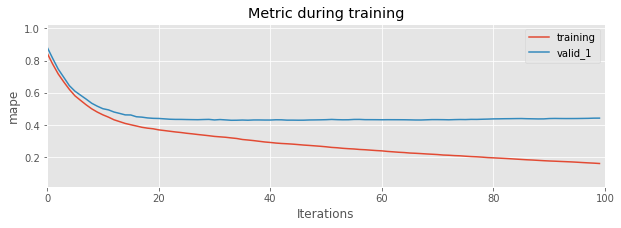

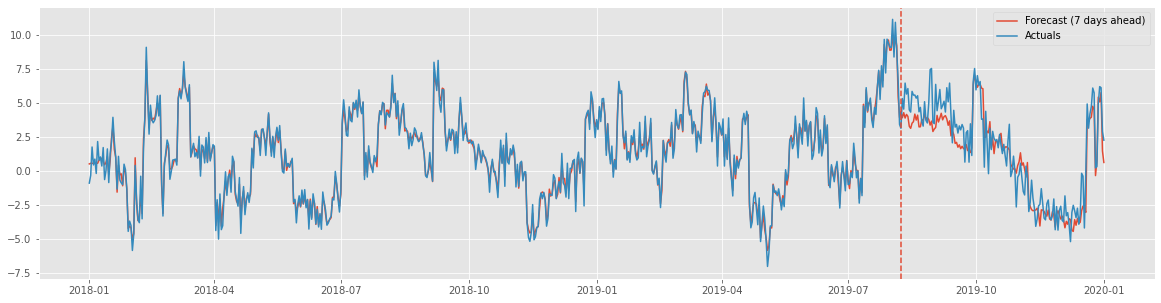

In [5]:
#
# engineer features for the model
#
def features_regression(df):       
    observed_features = ['covariate_01', 'covariate_02', 'covariate_03']    
    dff = df[['signal'] + observed_features]
    
    dff['year'] = dff.index.year
    dff['month'] = dff.index.month
    dff['day_of_year'] = dff.index.dayofyear

    feature_lags = [7, 14, 21, 28, 35, 42, 49, 120, 182, 365]
    for lag in feature_lags:
        dff.loc[:, f'signal_lag_{lag}'] = dff['signal'].shift(periods=lag, fill_value=0).values
        
    return dff

#
# train-test split
#
def split_train_test(df, train_ratio):    
    y_train, y_test = [], []
    x_train, x_test = [], []
    split_t = int(len(df)*train_ratio)
    
    y = df['signal']
    y_train = y[:split_t]
    y_test = y[split_t:]
            
    xdf = df.drop('signal', inplace=False, axis=1)
    x_train = xdf[:split_t]
    x_test = xdf[split_t:]
    
    return x_train, y_train, x_test, y_test

#
# fit LightGBM model
#
def fit_lightgbm(x_train, y_train, x_test, y_test, n_estimators=100, verbose_eval=50):
     
    model = lightgbm.LGBMRegressor(
        boosting_type = 'gbdt',
        #num_leaves = 8 - 1,
        n_estimators=n_estimators)
    
    model.fit(x_train, 
              y_train, 
              eval_set=[(x_train, y_train), (x_test, y_test)], 
              eval_metric='mape', 
              verbose=verbose_eval)
    
    return model

def fit_xgboost(x_train, y_train, x_test, y_test, n_estimators=20, verbose_eval=50):
    
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
                                 booster='gbtree',
                                 n_estimators=n_estimators)
    xgb_model.fit(x_train, 
                  y_train, 
                  eval_set=[(x_train, y_train), (x_test, y_test)],
                  eval_metric='rmse', 
                  verbose=verbose_eval)
    
    return xgb_model

def plot_xgboost_metric(model):
    results = model.evals_result()
    x_axis = range(0, len(results['validation_0']['rmse']))
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax.legend()
    
#
# generate data sample and fit the model
#
df = features_regression(create_signal(links = [linear_link, linear_link, mem_link]))
train_ratio = 0.8
x_train, y_train, x_test, y_test = split_train_test(df, train_ratio)
model = fit_lightgbm(x_train, y_train, x_test, y_test)    # can use fit_xgboost as an alternative

#
# plot the fitting metrics
#
lightgbm.plot_metric(model, metric='mape', figsize=(10, 3))

#
# plot the forecast
#
forecast = model.predict(pd.concat([x_train, x_test]))

fig, ax = plt.subplots(1, figsize=(20, 5))
ax.plot(df.index, forecast, label='Forecast (7 days ahead)')
ax.plot(df.index, df['signal'], label='Actuals')
ax.axvline(x=df.index[int(len(df) * train_ratio)], linestyle='--')
ax.legend()
plt.show()

# Step 3: Estimate Confidence Intervals for the Forecast

In this step, we extend the forecasting procedure developed in the previous step to estimate not only the mean of the signal, but also the level of uncertainty. The uncertainty level can be described using confidence intervals around the mean or, alternatively, some parametric distribution for the forecasted samples can be estimated. We evaluate both approaches:
* Confidence intervals can be estimated using the quantile regression technique. This method requires to just change the loss function, and thus can be implemented using most ML frameworks. We use LightGBM that explitly supports quantile regression.
* Sample distributions can be estimated using more specialized methods. We NGBoost library that fits a parametric distribution (e.g. Normal) for each time step.

[50]	training's mape: 0.269698	training's l2: 0.453565	valid_1's mape: 0.768298	valid_1's l2: 3.98161
[100]	training's mape: 0.167024	training's l2: 0.169305	valid_1's mape: 0.771185	valid_1's l2: 3.92965


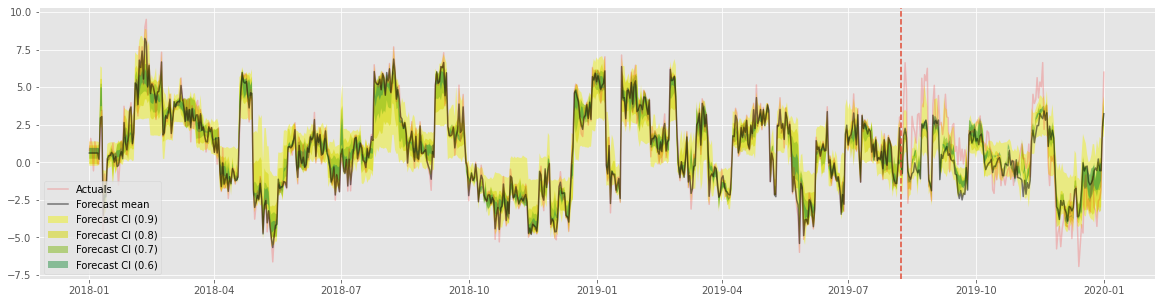

In [53]:
#
# fit the quantile regression model with LightGBM
#
def fit_lightgbm_quantile(x_train, y_train, x_test, y_test, alpha, n_estimators=100, verbose_eval=50):
     
    model = lightgbm.LGBMRegressor(
        boosting_type = 'gbdt',
        objective = 'quantile',
        alpha = alpha,
        num_leaves = 8 - 1,
        n_estimators=n_estimators)
    
    model.fit(x_train, 
              y_train, 
              eval_set=[(x_train, y_train), (x_test, y_test)], 
              eval_metric='mape', 
              verbose=verbose_eval)
    
    return model

#
# generate data sample and fit models
#
df = features_regression(create_signal(links = [linear_link, linear_link, mem_link]))
train_ratio = 0.8
x_train, y_train, x_test, y_test = split_train_test(df, train_ratio)
alphas = [0.90, 0.80, 0.70, 0.60]
model_mean = fit_lightgbm(x_train, y_train, x_test, y_test)   
models_upper = [fit_lightgbm_quantile(x_train, y_train, x_test, y_test, 1 - alpha, verbose_eval=0) for alpha in alphas]
models_lower = [fit_lightgbm_quantile(x_train, y_train, x_test, y_test, alpha, verbose_eval=0) for alpha in alphas]

#
# plot the forecasts
#
x = pd.concat([x_train, x_test])
forecasts_upper = [model.predict(x) for model in models_upper]
forecasts_lower = [model.predict(x) for model in models_lower]
forecast_mean = model_mean.predict(x)

fig, ax = plt.subplots(1, figsize=(20, 5))
pal = ["#eeef20", "#d4d700", "#80b918", "#2b9348"]
for i, alpha in enumerate(alphas):
    ax.fill_between(df.index, forecasts_lower[i], forecasts_upper[i], alpha=0.5, fc=pal[i], ec='None', label=f'Forecast CI ({alpha})')
ax.plot(df.index, df['signal'], color='r', alpha=0.2, label='Actuals')
ax.plot(df.index, forecast_mean, color='k', alpha=0.5, label='Forecast mean')
ax.axvline(x=df.index[int(len(df) * train_ratio)], linestyle='--')
ax.legend()
plt.show()

[iter 0] loss=2.4822 val_loss=0.0000 scale=1.0000 norm=2.4557
[iter 100] loss=2.0088 val_loss=0.0000 scale=1.0000 norm=1.4750
[iter 200] loss=1.6108 val_loss=0.0000 scale=2.0000 norm=2.1368
[iter 300] loss=1.3838 val_loss=0.0000 scale=1.0000 norm=0.9482
[iter 400] loss=1.2676 val_loss=0.0000 scale=1.0000 norm=0.9030


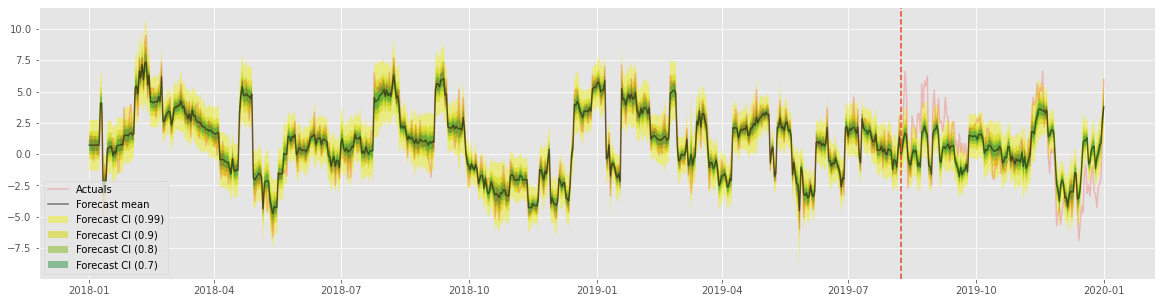

In [105]:
from ngboost import NGBRegressor  # see https://github.com/stanfordmlgroup/ngboost
from scipy.stats import norm

ngb = NGBRegressor().fit(x_train, y_train)
y_preds = ngb.predict(x)
y_dists = ngb.pred_dist(x)

fig, ax = plt.subplots(1, figsize=(20, 5))
alphas = [0.99, 0.90, 0.80, 0.70]
pal = ["#eeef20", "#d4d700", "#80b918", "#2b9348"]
for i, alpha in enumerate(alphas):
    rng = norm(loc=0.0, scale=y_dists.params['scale']).ppf(alpha) 
    ax.fill_between(df.index, y_preds + rng, y_preds - rng, alpha=0.5, fc=pal[i], ec='None', label=f'Forecast CI ({alpha})')
ax.plot(df.index, df['signal'], color='r', alpha=0.2, label='Actuals')
ax.plot(df.index, y_preds, color='k', alpha=0.5, label='Forecast mean')
ax.axvline(x=df.index[int(len(df) * train_ratio)], linestyle='--')
ax.legend()
plt.show()

# Step 4: Estimate Contribution of the Covariates

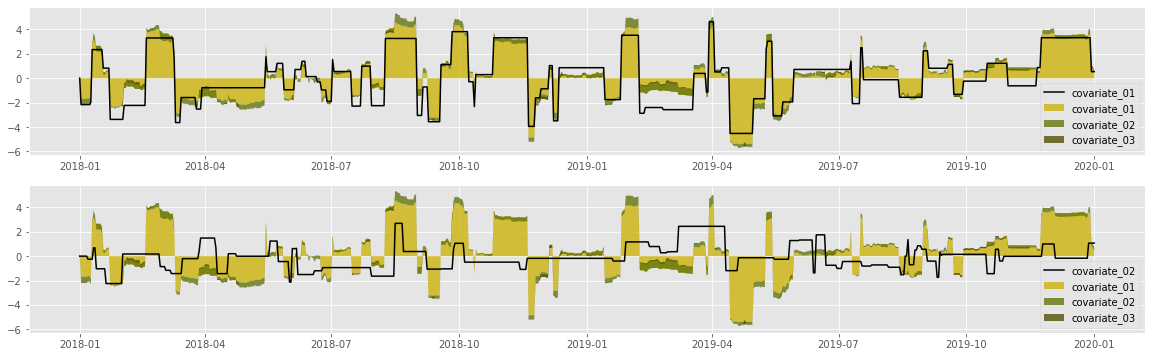

In [108]:
def patch_model(model): # see https://github.com/slundberg/shap/issues/1215
    if isinstance(model, xgb.XGBRegressor):
        booster = model.get_booster()
        model_bytearray = booster.save_raw()[4:]
        def get_barray(self=None):
            return model_bytearray
        booster.save_raw = get_barray

patch_model(model)
series_to_explain = pd.concat([x_train, x_test])
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(series_to_explain)

feature_names=['covariate_01', 'covariate_02', 'covariate_03']
cols = [series_to_explain.columns.get_loc(c) for c in feature_names]
values = shap_values[:, cols]
fig, ax = plt.subplots(2, figsize=(20, 6))
pal = ["#cdb30c", "#62760c", "#535204"]
for i in [0, 1]:
    ax[i].stackplot(series_to_explain.index, values.T, colors=pal, alpha=0.8, labels=feature_names)
    ax[i].plot(series_to_explain.index, series_to_explain[f'covariate_0{i+1}'], color='k', label=f'covariate_0{i+1}')
    ax[i].legend()

# Step 5: Estimate Shapes of the Link Functions (Linear and Non-linear Covariates)

[50]	training's mape: 0.257561	training's l2: 0.413264	valid_1's mape: 0.521078	valid_1's l2: 2.6153
[100]	training's mape: 0.159552	training's l2: 0.157502	valid_1's mape: 0.530819	valid_1's l2: 2.74012


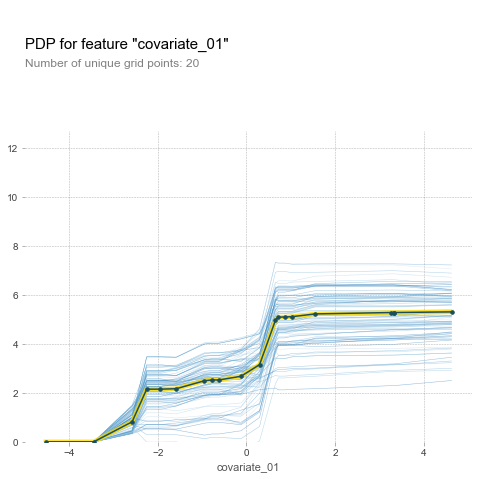

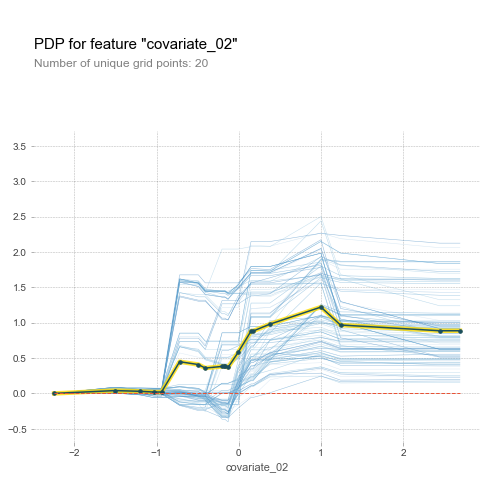

In [109]:
df = features_regression(create_signal(links = [linear_link, sigmoid_link, mem_link]))
train_ratio = 0.8
x_train, y_train, x_test, y_test = split_train_test(df, train_ratio)
model = fit_lightgbm(x_train, y_train, x_test, y_test)

for i in [1, 2]:
    pdp_isolate = pdp.pdp_isolate(
        model=model, 
        dataset=series_to_explain, 
        model_features=series_to_explain.columns, 
        feature=f'covariate_0{i}',
        num_grid_points=20)
    fig, ax = pdp.pdp_plot(pdp_isolate, f'covariate_0{i}', plot_lines=True, frac_to_plot=100, figsize=(8,8) )
    
plt.show()

# Step 6: Estimate the Shape of the Link Function with Memory Effects

In this step, we estimate memory effects using shifted copies of the covariate. This approach can produce meaningful results, but it is not stable because of complex non-linear nature of GBDT. Techniques like VAR and BSTS offer better alernatives in many cases.  

[50]	training's mape: 0.333486	training's l2: 0.676695	valid_1's mape: 0.591579	valid_1's l2: 3.36169
[100]	training's mape: 0.294396	training's l2: 0.524305	valid_1's mape: 0.593533	valid_1's l2: 3.36469


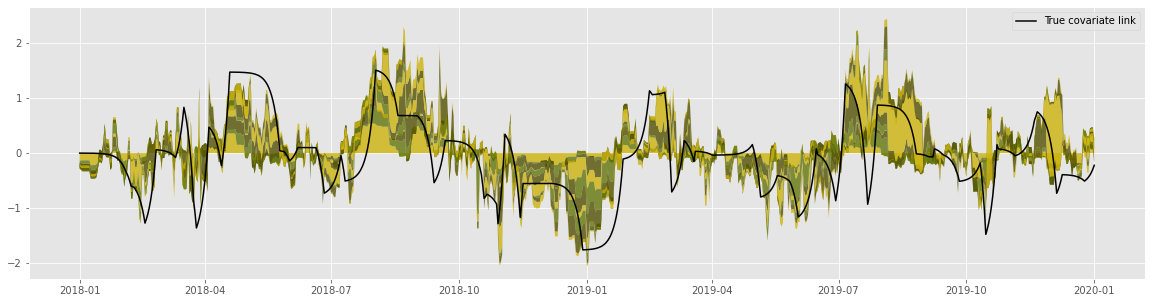

In [126]:
#
# explain memory effects
#
df_original = create_signal()
observed_features = ['covariate_01', 'covariate_02'] 
df = df_original[['signal'] + observed_features]
df['year'] = df.index.year
df['month'] = df.index.month
df['day_of_year'] = df.index.dayofyear
lags = np.arange(0, 50, 5)
for lag in lags:
    df.loc[:, f'covariate_03_lag_{lag}'] = df_original['covariate_03'].shift(periods=lag, fill_value=0).values

x_train, y_train, x_test, y_test = split_train_test(df, train_ratio)
model = fit_lightgbm(x_train, y_train, x_test, y_test)

series_to_explain = pd.concat([x_train, x_test])
patch_model(model)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(series_to_explain)

feature_names=[f'covariate_03_lag_{lag}' for lag in lags]
cols = [series_to_explain.columns.get_loc(c) for c in feature_names]
values = shap_values[:, cols]
fig, ax = plt.subplots(1, figsize=(20, 5))
pal = ["#cdb30c", "#62760c", "#535204"]
ax.stackplot(series_to_explain.index, values.T, colors=pal, alpha=0.8)
ax.plot(series_to_explain.index, df_original['covariate_03_link'], color='k', label='True covariate link')
plt.legend()
plt.show()